In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 
import missingno as msno
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import cufflinks as cf #importing plotly and cufflinks in offline mode  
import plotly.offline 
import squarify

# 資料概述

In [128]:
"""
可視化部分參考(抄襲):
https://www.kaggle.com/subinium/road-to-viz-expert-1-unusual-tools
https://seaborn.pydata.org/examples/index.html
https://www.kaggle.com/hkhoi91/data-viz-what-to-focus-on-as-a-game-dev

stata參考:https://github.com/TiesdeKok/ipystata/blob/master/ipystata/Example_batch.ipynb
此外
因為沒有下載數量,但用戶討論數量應可以代表下載量(有下載才會討論)

"""

'\n可視化部分參考(抄襲):\nhttps://www.kaggle.com/subinium/road-to-viz-expert-1-unusual-tools\nhttps://seaborn.pydata.org/examples/index.html\nhttps://www.kaggle.com/hkhoi91/data-viz-what-to-focus-on-as-a-game-dev\n\nstata參考:https://github.com/TiesdeKok/ipystata/blob/master/ipystata/Example_batch.ipynb\n此外\n因為沒有下載數量,但用戶討論數量應可以代表下載量(有下載才會討論)\n\n'

In [100]:
df = pd.read_csv(r'C:\Users\user\Desktop\class\數據分析\adj_appstore_games.csv')
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
df.drop(['URL', 'ID','Name','Subtitle','Icon URL','In-app Purchases','Description','Developer','Languages','Primary Genre','Genres','Original Release Date','Current Version Release Date'], axis = 1,inplace = True)
df = pd.get_dummies(df, dummy_na=True)      
df.drop(['Age Rating_12+', 'Age Rating_4+','Age Rating_9+','Age Rating_nan'], axis = 1,inplace = True)
conditions = [
    (df['Size'] > 138254336),
    (df['Size'] <=138254335)]
choices = [1,0]
df['Size'] = np.select(conditions, choices)

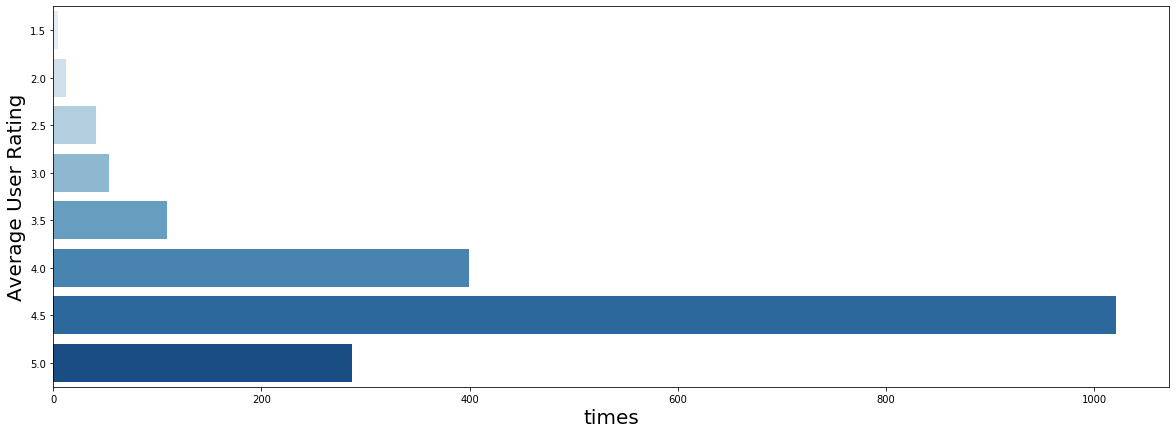

In [101]:
"""
評分以4.5分最多呈現左偏
"""
plt.figure(figsize=(20, 7)) 
ax = sns.countplot(data = df, y =r'Average User Rating', palette = 'Blues')
ax.set_ylabel(r'Average User Rating', fontsize = 20)
ax.set_xlabel('times', fontsize = 20)
plt.show()

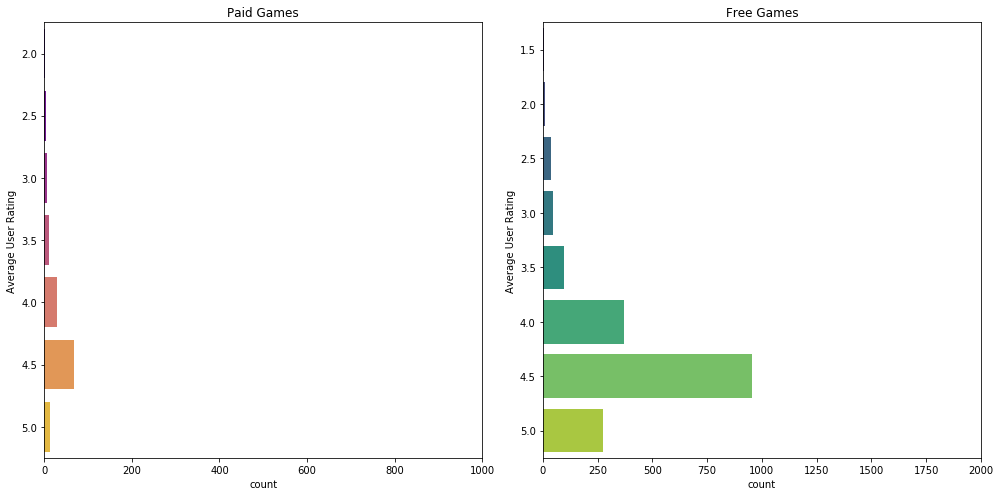

In [75]:
"""
付費遊戲與免費遊戲之評分比較圖
"""
paid = df[df['Price']>0]
free = df[df['Price']==0]
fig, ax = plt.subplots(1, 2, figsize=(14,7))
sns.countplot(data=paid, y='Average User Rating', ax=ax[0], palette='plasma')
ax[0].set_title('Paid Games')
ax[0].set_xlim([0, 1000])

sns.countplot(data=free, y='Average User Rating', ax=ax[1], palette='viridis')
ax[1].set_title('Free Games')
ax[1].set_xlim([0,2000])
plt.tight_layout();
plt.show()

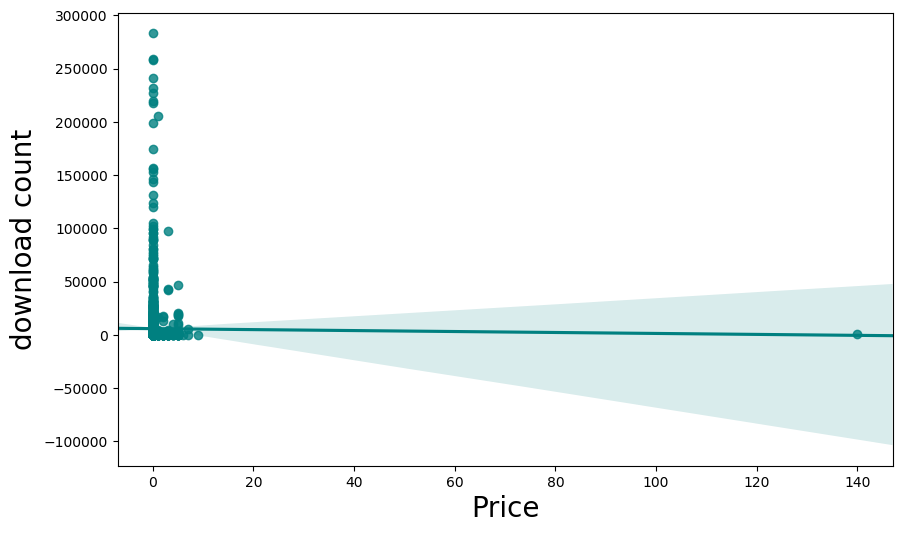

In [76]:
"""
因為沒有下載量,但評論數量與下載量應該呈現高度正向關(下載後才會評論)
價格與下載次數呈現負相關
"""
plt.figure(figsize=(10,6), dpi= 100)
ax = sns.regplot(data=df, x='Price', y='User Rating Count', color = 'teal')
ax.set_ylabel('download count', fontsize = 20)
ax.set_xlabel('Price', fontsize = 20)
plt.show()

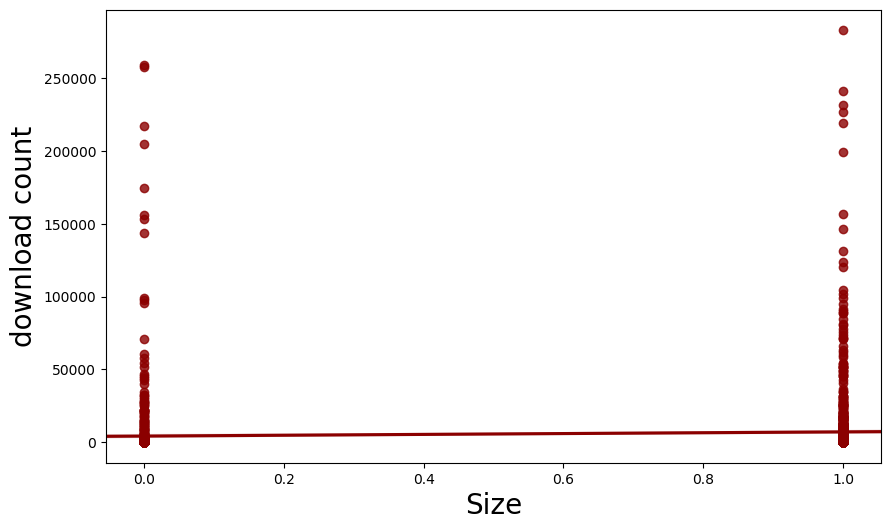

In [77]:
"""
檔案大小與下載次數呈現正相關
這個是後面要探討的議題
"""
plt.figure(figsize=(10,6), dpi= 100)
ax = sns.regplot(data=df, x='Size', y='User Rating Count', color = 'darkred')
ax.set_ylabel('download count', fontsize = 20)
ax.set_xlabel('Size', fontsize = 20)
plt.show()

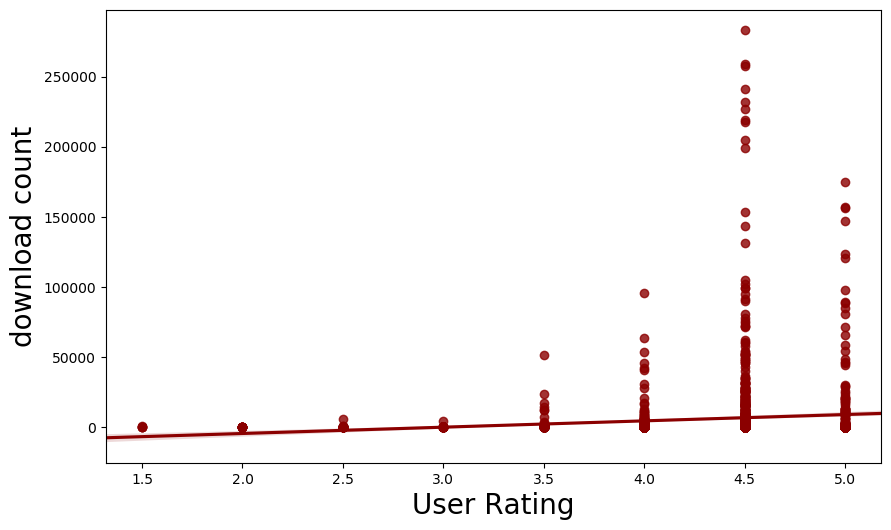

In [78]:
"""
評分與下載數量呈現正相關
"""
plt.figure(figsize=(10,6), dpi= 100)
ax = sns.regplot(data=df, x='Average User Rating', y='User Rating Count', color = 'darkred')
ax.set_ylabel('download count', fontsize = 20)
ax.set_xlabel('User Rating', fontsize = 20)
plt.show()

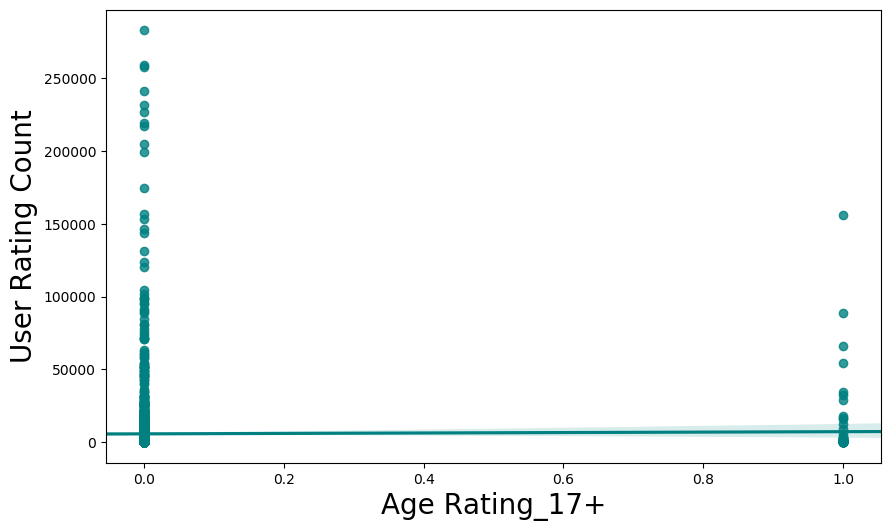

In [73]:
##age使用dummy 17+

plt.figure(figsize=(10,6), dpi= 100)
ax = sns.regplot(data=df, x='Age Rating_17+', y='User Rating Count', color = 'teal')
ax.set_ylabel('User Rating Count', fontsize = 20)
ax.set_xlabel('Age Rating_17+', fontsize = 20)
plt.show()

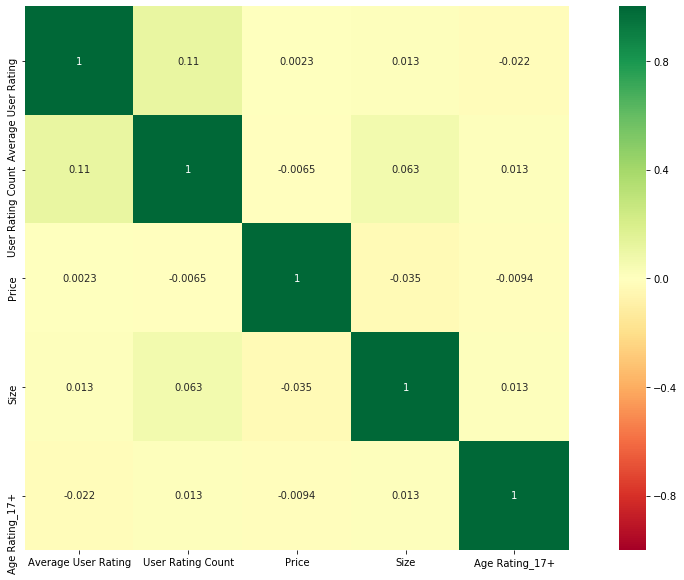

In [83]:
"""
相關係數矩陣
"""
plt.rcParams['figure.figsize'] = (18,10)
sns.heatmap(df.corr(), vmin=-1, vmax=1, center=0,
            square=True, annot = True, cmap = 'RdYlGn')
plt.show()

# 因果推論-選擇性偏誤

In [2]:
import ipystata
from ipystata.config import config_stata
config_stata(r'C:\Users\user\Desktop\Program\stata\Stata14-20190808T142556Z-001\Stata14\StataSE-64.exe')
df2 = pd.read_excel(r'C:\Users\user\Desktop\class\數據分析\data_psm3.xls')

In [110]:
df2.head()

,Unnamed: 0,AverageUserRating,UserRatingCount,Price,Size,AgeRatingover17
0,0,4.5,283035,0.0,1,0
1,2,4.5,259030,0.0,0,0
2,3,4.5,257852,0.0,0,0
3,4,4.5,240990,0.0,1,0
4,5,4.5,231877,0.0,1,0


In [5]:
%%stata  
regress UserRatingCount Price AverageUserRating AgeRatingover17 Size


      Source |       SS           df       MS      Number of obs   =     1,928
-------------+----------------------------------   F(4, 1923)      =      8.13
       Model |  1.6484e+10         4  4.1209e+09   Prob > F        =    0.0000
    Residual |  9.7486e+11     1,923   506948817   R-squared       =    0.0166
-------------+----------------------------------   Adj R-squared   =    0.0146
       Total |  9.9135e+11     1,927   514450531   Root MSE        =     22516

-----------------------------------------------------------------------------------
  UserRatingCount |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
------------------+----------------------------------------------------------------
            Price |  -30.95883   156.0256    -0.20   0.843    -336.9559    275.0382
AverageUserRating |   4485.002   909.0761     4.93   0.000     2702.123     6267.88
  AgeRatingover17 |   1689.764   2587.691     0.65   0.514     -3385.21    6764.739
             Size | 

In [113]:
"""
從迴歸結果可以看到Size(APP大小)與UserRatingCount(下載量) 為顯著正相關
然而這不能代表:提升APP大小可以增加下載次數
因:APP大小並非"隨機"被決定,兩者間也未必有因果關係

因此下邊使用Propensity Score Matching(PSM)藉由配對的方式控制其他變數,盡量使Size effect呈現一個隨機的狀態,再來觀測Size對於下載量的影響 
"""

'\n從迴歸結果可以看到Size(APP大小)與UserRatingCount(下載量) 為顯著正相關\n然而這不能代表:提升APP大小可以增加下載次數\n因:APP大小並非"隨機"被決定,兩者間也未必有因果關係\n\n因此下邊使用Propensity Score Matching(PSM)藉由配對的方式控制其他變數,盡量使Size effect呈現一個隨機的狀態,再來觀測Size對於下載量的影響 \n'

In [7]:
%%stata -d df2

display "psm result"
psmatch2 Size AverageUserRating Price AgeRatingover17  ,outcome( UserRatingCount )

display "psm_Balanced detection "
pstest,both


psm result

Probit regression                               Number of obs     =      1,928
                                                LR chi2(3)        =       5.50
                                                Prob > chi2       =     0.1385
Log likelihood = -1323.4514                     Pseudo R2         =     0.0021

-----------------------------------------------------------------------------------
             Size |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
------------------+----------------------------------------------------------------
AverageUserRating |   .0285926   .0507157     0.56   0.573    -.0708085    .1279936
            Price |  -.0619582   .0345107    -1.80   0.073    -.1295979    .0056815
  AgeRatingover17 |    .078051   .1453056     0.54   0.591    -.2067427    .3628447
            _cons |   .0154761   .2206954     0.07   0.944    -.4170788    .4480311
----------------------------------------------------------------------------------

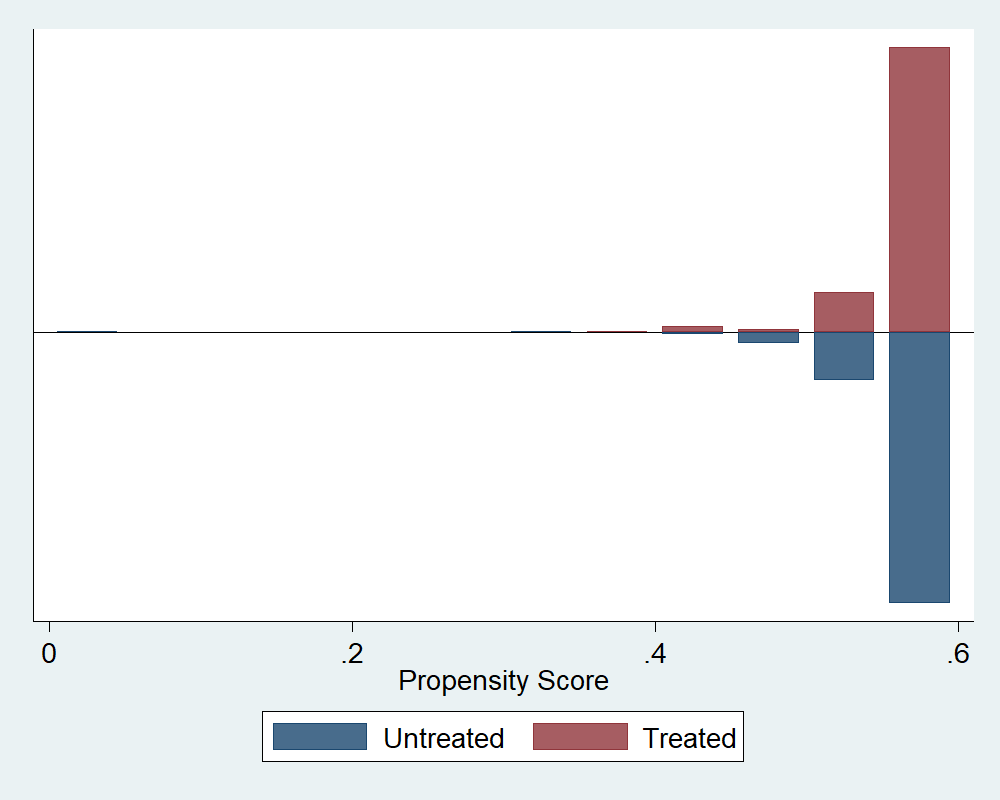

In [8]:
%%stata -gr
psgraph

In [9]:
"""
psm result:
可以看到,在配對之前,大容量的APP平均下載量為7045,高於小容量的4158
在配對之後,大容量的APP平均下載量為7045,低於小容量的176667
這說明在其他條件不變下,APP大小愈小愈能得到高的下載次數

psm_Balanced detection:
U:Umatch
M:Match
可以看到在配對之後實驗組與控制組之變數值無顯著差異
圖表也可看到配對大致均衡
"""

'\npsm result:\n可以看到,在配對之前,大容量的APP平均下載量為7045,高於小容量的4158\n在配對之後,大容量的APP平均下載量為7045,低於小容量的176667\n這說明在其他條件不變下,APP大小愈小愈能得到高的下載次數\n\npsm_Balanced detection:\nU:Umatch\nM:Match\n可以看到在配對之後實驗組與控制組之變數值無顯著差異\n圖表也可看到配對大致均衡\n'

In [10]:
"""
結論:
一般的迴歸由於不正確的因果關係得到APP大小與下載量呈現正相關的結論
藉由PSM排除選擇性偏誤得到APP大小與下載量呈現反向關係的結論
"""

'\n結論:\n一般的迴歸由於不正確的因果關係得到APP大小與下載量呈現正相關的結論\n藉由PSM排除選擇性偏誤得到APP大小與下載量呈現反向關係的結論\n'

# 參考

In [188]:
#參考
"""
轉區間
https://guillim.github.io/pandas/2018/10/22/Pandas-if-else-on-columns.html


"""

'\n轉區間\nhttps://guillim.github.io/pandas/2018/10/22/Pandas-if-else-on-columns.html\n\n\n'